In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
import re
from torchvision import transforms
import json
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# 要用git clone 手動下載這個dataset，再移到相對位置

dataset = load_dataset("imagefolder", data_dir="./Dataset/train")

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = self.transform(example["image"])
        label = example["label"]
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((75, 50)),
    transforms.ToTensor()
])

split = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = TransformedDataset(split["train"], transform)
val_dataset = TransformedDataset(split["test"], transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform, label_map):
        self.img_paths = []
        self.labels = []
        self.transform = transform
        self.label_map = label_map

        for file in os.listdir(img_dir):
            if not file.endswith(".png"):
                continue
            label_str = file.split("_")[-1].split(".")[0]
            if label_str.upper() == "UNKNOWN":
                continue
            if label_str not in label_map:
                continue 
            self.img_paths.append(os.path.join(img_dir, file))
            self.labels.append(label_map[label_str])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("L")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label
    
# e.g., {"G1": 0, "M17": 1, ...}
with open("output/label_map.json", "r") as f:
    label_map = json.load(f)
test_dataset = TestDataset(img_dir="./Dataset/test", transform=transform, label_map=label_map)
test_loader = DataLoader(test_dataset, batch_size=64)

class EgyptianCNN(nn.Module):
    def __init__(self, num_classes):
        super(EgyptianCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 17 * 11, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, return_features=False):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        features = F.relu(self.fc1(x))
        if return_features:
            return features
        return self.fc2(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_map)
model = EgyptianCNN(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("output/egyptian_cnn_weights.pth", map_location=torch.device("cpu")))
model.eval()

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            feats = model(images, return_features=True)
            features.append(feats.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

X_train_feats, y_train = extract_features(model, train_loader)
X_test_feats, y_test = extract_features(model, test_loader)

lda_components = 32 # 

lda = LinearDiscriminantAnalysis(n_components=lda_components)
x_train_lda = lda.fit_transform(X_train_feats, y_train)
x_test_lda = lda.transform(X_test_feats)

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\ted12\AppData\Local\Temp\ipykernel_81080\1912826695.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# LDA + K-means clustering

n_clusters = 170

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(x_test_lda)

ari = adjusted_rand_score(y_test, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Adjusted Rand Index (ARI): 0.3100


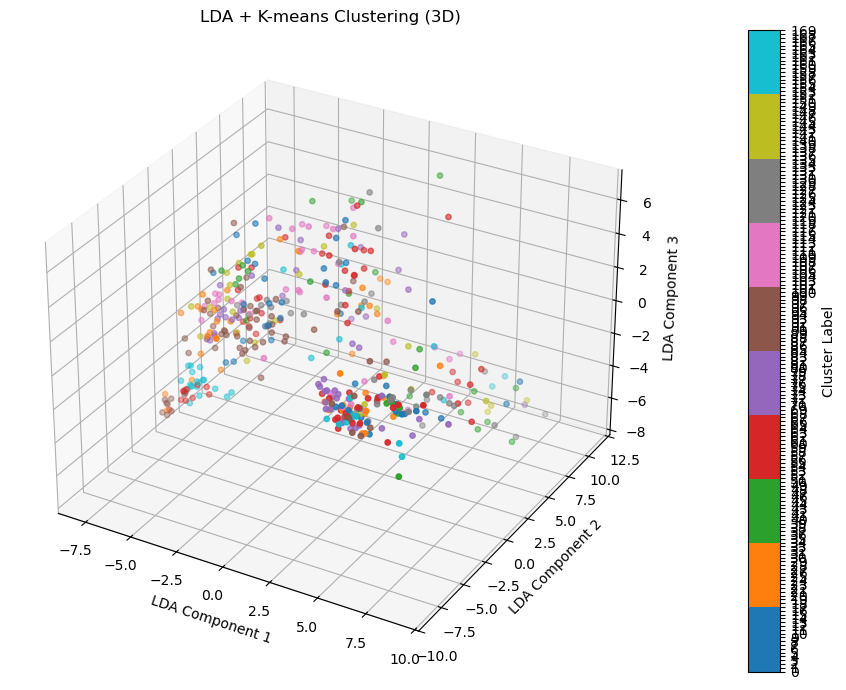

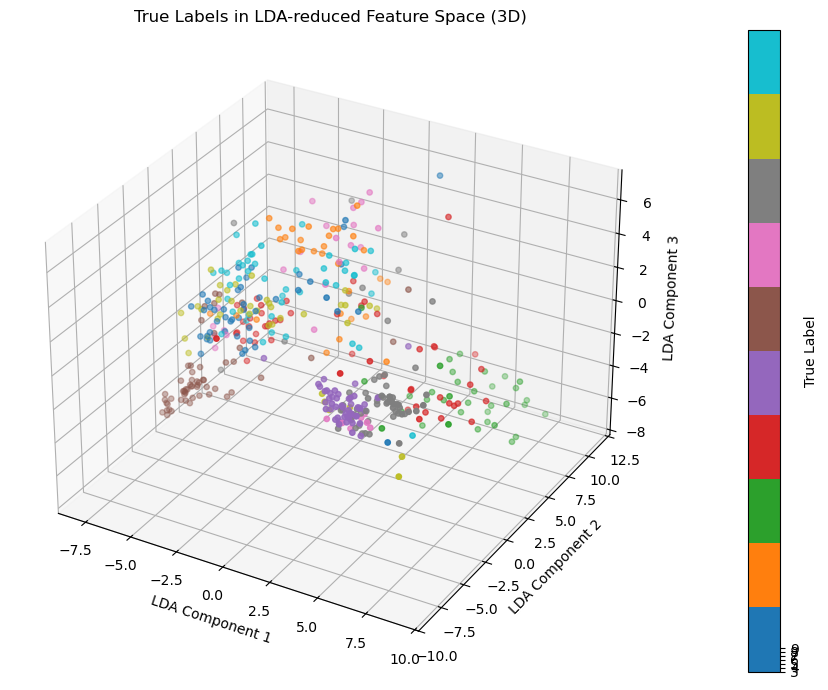

In [10]:
from mpl_toolkits.mplot3d import Axes3D  # 3D 畫圖工具

lda_components = 32
lda = LinearDiscriminantAnalysis(n_components=lda_components)
x_train_lda = lda.fit_transform(X_train_feats, y_train)
x_test_lda = lda.transform(X_test_feats)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_test_lda[:, 0], x_test_lda[:, 1], x_test_lda[:, 2],
                     c=cluster_labels, cmap='tab10', s=15)
ax.set_title("LDA + K-means Clustering (3D)")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
fig.colorbar(scatter, ax=ax, pad=0.1, ticks=range(n_clusters), label="Cluster Label")
plt.tight_layout()
# plt.savefig("lda_kmeans_clusters_3d.png")
plt.show()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter_gt = ax.scatter(x_test_lda[:, 0], x_test_lda[:, 1], x_test_lda[:, 2],
                        c=y_test, cmap='tab10', s=15)
ax.set_title("True Labels in LDA-reduced Feature Space (3D)")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
fig.colorbar(scatter_gt, ax=ax, pad=0.1, ticks=range(10), label="True Label")
plt.tight_layout()
# plt.savefig("lda_true_labels_3d.png")
plt.show()


In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# LDA + EM algorithm

n_components = 170

gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(x_test_lda)

cluster_labels = gmm.predict(x_test_lda)

ari = adjusted_rand_score(y_test, cluster_labels)
print(f"EM Clustering ARI: {ari:.4f}")

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


EM Clustering ARI: 0.2763


In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

gnb = GaussianNB()
gnb.fit(x_train_lda, y_train)

y_pred = gnb.predict(x_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix: CNN Feature + LDA + GNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join("./results/LDA_GNB", "confusion_matrix_cnn_lda_gnb.png"))
plt.close()

report = classification_report(y_test, y_pred, output_dict=True)
flat_report = {
    f"{label}_{metric}": score
    for label, scores in report.items() if isinstance(scores, dict)
    for metric, score in scores.items()
}
flat_report["accuracy"] = accuracy
flat_report["lda_components"] = lda_components

df = pd.DataFrame([flat_report])
df.to_csv(os.path.join("./results/LDA_GNB", "classification_report_cnn_lda_gnb.csv"), index=False)


✅ Accuracy: 0.7523
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.50      0.67         6
          10       0.82      1.00      0.90        18
          11       0.50      1.00      0.67         1
          13       1.00      0.88      0.93         8
          14       1.00      1.00      1.00         4
          16       1.00      1.00      1.00         2
          17       0.50      0.33      0.40         3
          18       0.00      0.00      0.00         1
          22       0.12      0.50      0.20         2
          25       0.00      0.00      0.00         4
          27       0.00      0.00      0.00         3
          28       0.85      1.00      0.92        17
          29       1.00      0.67      0.80         3
          32       0.00      0.00      0.00         2
        

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

clf = SVC(kernel='rbf', gamma='scale', probability=True)
clf.fit(x_train_lda, y_train)

y_pred = clf.predict(x_test_lda)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
print(f"✅ Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix: CNN Feature + LDA + SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join("./results/LDA_SVM", "confusion_matrix_cnn_lda_svm.png"))
plt.close()

flat_report = {
    f"{label}_{metric}": value
    for label, scores in report.items() if isinstance(scores, dict)
    for metric, value in scores.items()
}
flat_report["lda_components"] = lda_components
flat_report["accuracy"] = accuracy

df = pd.DataFrame([flat_report])
df.to_csv(os.path.join("./results/LDA_SVM", "classification_report_cnn_lda_svm.csv"), index=False)


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ted12\anaconda3\envs\NLP\Li

✅ Accuracy: 0.7860
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         1
           9       1.00      0.83      0.91         6
          10       0.75      1.00      0.86        18
          11       0.50      1.00      0.67         1
          13       1.00      0.88      0.93         8
          14       0.67      1.00      0.80         4
          16       1.00      1.00      1.00         2
          17       0.33      0.33      0.33         3
          18       0.00      0.00      0.00         1
          22       0.67      1.00      0.80         2
          25       1.00      1.00      1.00         4
          27       1.00      0.67      0.80         3
          28       0.85      1.00      0.92        17
          29       1.00      0.67      0.80         3
          32       1.00      0.50      0.67         2
        